In [68]:
import os
import pandas as pd
import requests
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB1
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import FileUpload
import io
from PIL import Image
import shutil
from tqdm.notebook import tqdm as tq
import keras
from tensorflow.keras.models import load_model

In [6]:
mypath="Plant/" 

In [7]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name).replace("\\","/")) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [8]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
aloevera          1000
banana            1000
bilimbi           1000
cantaloupe        1000
cassava           1000
coconut           1000
corn              1000
cucumber          1000
curcuma           1000
eggplant          1000
galangal          1000
ginger            1000
guava             1000
kale              1000
longbeans         1000
mango             1000
melon             1000
orange            1000
paddy             1000
papaya            1000
peper chili       1000
pineapple         1000
pomelo            1000
shallot           1000
soybeans          1000
spinach           1000
sweet potatoes    1000
tobacco           1000
waterapple        1000
watermelon        1000
dtype: int64

In [9]:
df.head()

,path,file_name,tag
0,Plant/aloevera/aloevera0.jpg,aloevera0.jpg,aloevera
1,Plant/aloevera/aloevera1.jpg,aloevera1.jpg,aloevera
2,Plant/aloevera/aloevera10.jpg,aloevera10.jpg,aloevera
3,Plant/aloevera/aloevera100.jpg,aloevera100.jpg,aloevera
4,Plant/aloevera/aloevera101.jpg,aloevera101.jpg,aloevera


In [10]:
#load library untuk train test split
from sklearn.model_selection import train_test_split
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [11]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)

In [12]:
# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)

In [13]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [14]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 24000
val size 3000
test size 3000


In [15]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample()


set         tag           
test        aloevera          101
            banana             99
            bilimbi            98
            cantaloupe         96
            cassava           117
                             ... 
validation  spinach            94
            sweet potatoes     95
            tobacco           106
            waterapple        107
            watermelon         96
Length: 90, dtype: int64 




,path,tag,set
24909,Plant/paddy/paddy534.jpg,paddy,test


In [16]:
datasource_path = "flowers/"
dataset_path = "dataset/"

In [17]:
for index, row in tq(df_all.iterrows(), ):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Train Model

In [19]:
# Define Input Parameters
dim = (160, 160)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

In [20]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [21]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 24000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.


In [22]:
print(labels)

dict_keys(['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon'])


In [23]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [24]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [26]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 128)     3584      
                                                                 
 activation (Activation)     (None, 160, 160, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 158, 158, 32)      36896     
                                                                 
 activation_1 (Activation)   (None, 158, 158, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                        

In [28]:
# get base models
base_model = MobileNetV2(
    input_shape= input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

In [30]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [31]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [33]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

In [35]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 80, 80, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 80, 80, 32)   0           ['stem_bn[0][0]']          

 block2a_activation (Activation  (None, 40, 40, 96)  0           ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 96)          0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 96)     0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 4)      388         ['block2a_se_reshape[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 40, 40, 144)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 40, 40, 24)   3456        ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 40, 40, 24)  96          ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_d

 block3b_drop (FixedDropout)    (None, 20, 20, 40)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 20, 20, 40)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, 20, 20, 240)  9600        ['block3b_add[0][0]']            
                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 20, 20, 240)  960        ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_e

 block4b_expand_activation (Act  (None, 10, 10, 480)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 10, 10, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 10, 10, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 10, 10, 480)  0          ['block4b_bn[0][0]']             
 )        

                                                                                                  
 block4d_bn (BatchNormalization  (None, 10, 10, 480)  1920       ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 10, 10, 480)  0          ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 480)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 10, 10, 672)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5b_se_excite[0][0]']      
          

                                                                                                  
 block5d_se_excite (Multiply)   (None, 10, 10, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 10, 10, 112)  0           ['block5d_project_bn[0][0]']     
          

                                                                                                  
 block6b_add (Add)              (None, 5, 5, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 5, 5, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6e_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  28800       ['block6e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6e_b

 block7b_bn (BatchNormalization  (None, 5, 5, 1920)  7680        ['block7b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7b_activation (Activation  (None, 5, 5, 1920)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 1920)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7b_se_reshape (Reshape)   (None, 1, 1, 1920)   0           ['block7b_se_squeeze[0][0]']     
          

In [36]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


# Visualize the final model

In [37]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
EPOCH = 2

In [39]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/2
1500/1500 [==============================] - 5737s 4s/step - loss: 1.3546 - accuracy: 0.6076 - val_loss: 1.0983 - val_accuracy: 0.6923
Epoch 2/2
1500/1500 [==============================] - 5475s 4s/step - loss: 0.9438 - accuracy: 0.7177 - val_loss: 0.9418 - val_accuracy: 0.7250


In [40]:
history.history['loss']

[1.354622483253479, 0.9438013434410095]

In [41]:
history.history['accuracy']

[0.6076250076293945, 0.7176666855812073]

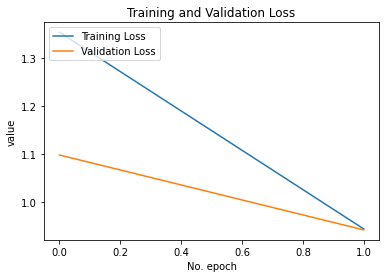

In [42]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

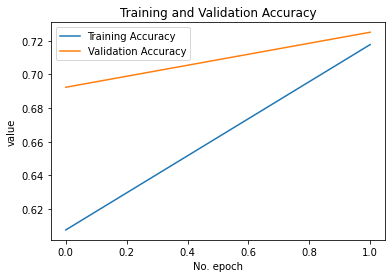

In [43]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [44]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)    
    

Saving Model At model\medium_project\model.h5...


In [45]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.7515 
Loss on training data: 0.8136 

Accuracy on test data: 0.7293 
Loss on test data: 0.9326 



In [47]:
# Parameters
input_size = (160,160)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']

In [48]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

FileUpload(value={}, accept='.jpg, .png, .jpeg', description='Upload')

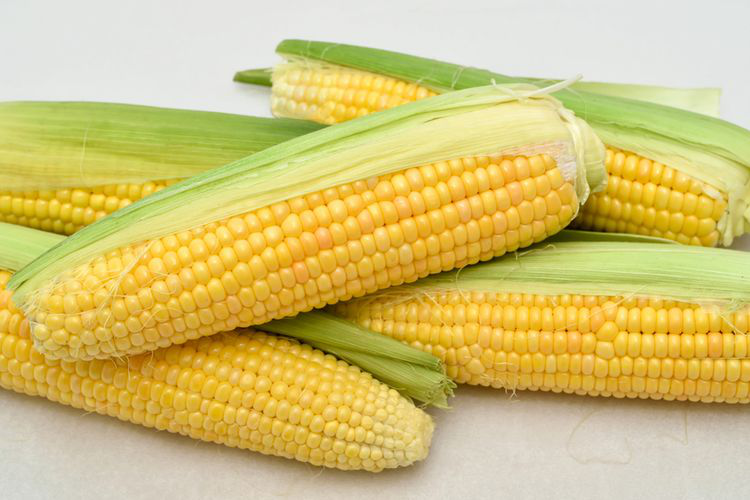

1/1 [==============================] - 6s 6s/step
corn


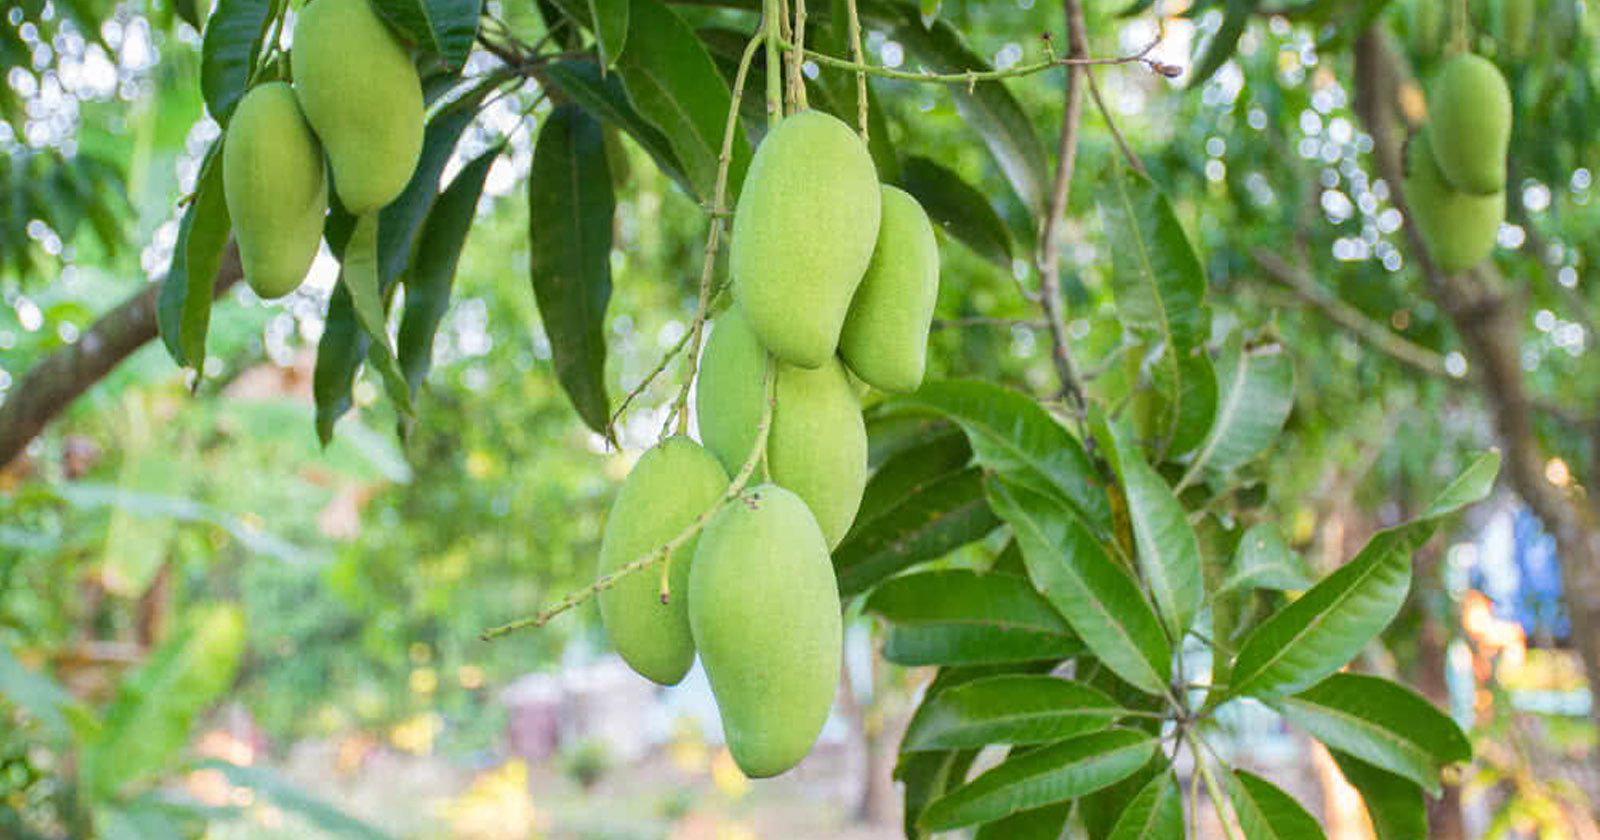

1/1 [==============================] - 0s 94ms/step
peper chili


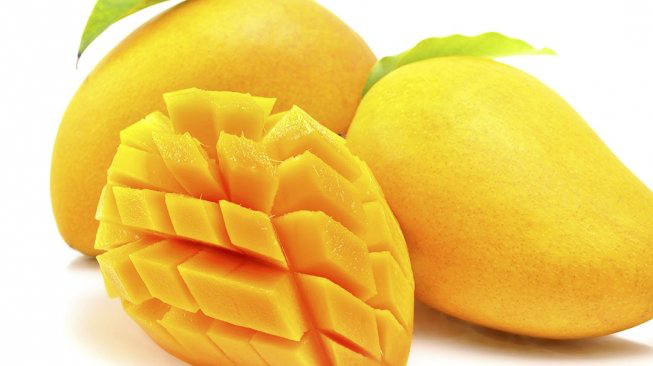

1/1 [==============================] - 0s 191ms/step
mango


In [51]:
# Fungsi untuk menampilkan gambar dari file yang diunggah
def display_uploaded_image(change):
    uploaded_filename, uploaded_file_info = list(uploader.value.items())[0]
    content = uploaded_file_info['content']
    image = Image.open(io.BytesIO(content))
    display(image)
    X = preprocess(image,input_size)
    X = reshape([X])
    y = model.predict(X)
    print(labels[np.argmax(y)])
    #print(labels[np.argmax(y)], np.max(y))

# Membuat widget untuk mengunggah file
uploader = FileUpload(accept='.jpg, .png, .jpeg', multiple=False)
uploader.observe(display_uploaded_image, names='value')

# Menampilkan widget
display(uploader)

In [71]:
train_model=load_model('model/medium_project/model.h5', compile=False)